Kaggle Installation:

In [1]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
! mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/

**Downloading Dataset:**

In [5]:
! kaggle datasets download ashishjangra27/face-mask-12k-images-dataset

 97% 320M/330M [00:02<00:00, 158MB/s]
100% 330M/330M [00:02<00:00, 149MB/s]


Extract:

In [6]:
from zipfile import ZipFile
zip = ZipFile('/content/face-mask-12k-images-dataset.zip')
zip.extractall()

**IMPORTS:**

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy


import torch
import torchvision
from torchvision import models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn

from __future__ import print_function, division

cudnn.benchmark=True
plt.ion()

In [8]:
from torchvision import datasets
from tqdm import tqdm

**Check for GPU:**

In [9]:
device="cuda" if torch.cuda.is_available() else "cpu"
print(device)    

cuda


**DATA LOADERS:**

Augmentation, Normalization, resize

In [10]:
data_transform={
    
    'Train':transforms.Compose([ #Augmentation + Resize + Normalization
        
        transforms.RandomResizedCrop(224), #224 X 224 imgs
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),                      #ImageNet's mean and SD values
        transforms.Normalize([0.485, 0.456, 0.406], #mean across each RGB channel
                             [0.229, 0.224, 0.225]) #SD across each RGB channel
                                                    #in range of (0,1)
    ]),
    
    'Validation': transforms.Compose([ #Resize + Normalization
        
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    
}            

**Path for dataset:**

In [11]:
Path="/content/Face Mask Dataset"

**Splitting for train and val:**

In [12]:
dataset={x: datasets.ImageFolder(os.path.join(Path, x),data_transform[x]) #splitting into train and val based on folder in dataset
          for x in ['Train', 'Validation']
        }

dataloaders={x:torch.utils.data.DataLoader(dataset[x], batch_size=5,shuffle=True, num_workers=4) #defining dataloader for the model, number of dataset batches=5
              for x in ['Train', 'Validation']
            }

dataset_Size={x:len(dataset[x]) for x in ['Train','Validation']} #Determining size

label=dataset['Train'].classes #fetching labels

device=torch.device("cuda:0") #prereq for passing data onto the gpu


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Checking:

In [13]:
print(dataset_Size, label)

{'Train': 10000, 'Validation': 800} ['WithMask', 'WithoutMask']


**SAMPLE:**

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


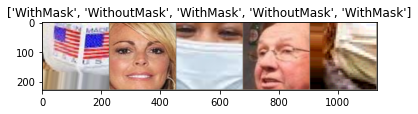

In [14]:
#BoilerPlate code for visualizing images with augs

def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


# Get a batch of training data
inputs, classes = next(iter(dataloaders['Train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[label[x] for x in classes])

**TRAINING Method:**

In [15]:
def training(model, criterion, optimizer, scheduler, epoch_count=20):
    
    start=time.time() #keep track of initial starting time for calculating elapsed time
    
    weight_of_BestModel=copy.deepcopy(model.state_dict()) #Initialize variables to save weights and accuracy of the best model that runs through the epoches
    
    acc_of_BestModel=0.0
    
    for epoch in range(epoch_count):
        
        print(f'Epoch Number: {epoch}/{epoch_count-1}') #displaying current epoch
        print('_'*20)
        
        for phase in['Train','Validation']: # 1 epoch = Training phase + Validation phase
            
            if phase=='Train':
                model.train()  #training phase
            else:
                model.eval() #eval phase
            
            running_loss=0.0
            running_corrects=0
            
            for inputs, labels in dataloaders[phase]:
                
                #passing dataset to GPU
                
                inputs=inputs.to(device)
                labels=labels.to(device)
                
                optimizer.zero_grad() #Zeroing gradients
                
                #enable gradients for forward pass
                
                with torch.set_grad_enabled(phase == 'Train'):
                    outputs=model(inputs) #passing inputs to model
                    _, prediction=torch.max(outputs,1) #(max val of output, preds)
                    loss=criterion(outputs, labels) #cross entropy fn b/w predicted output and actual label-->loss function
                   
                #Optimize for backward pass of Train
                
                    if phase == 'Train':
                        loss.backward() #calc gradients for backward pass
                        optimizer.step() #update parameters for each batch iteration
                        
                #Claculating loss
                
                running_loss=running_loss+ loss.item()*inputs.size(0)
                running_corrects=running_corrects+torch.sum(prediction==labels.data)
                
            if phase=='Train':
                scheduler.step() #change learning rate for each epoch-->lr deacy
             
            #Calc loss and acc for each epoch
            
            epoch_loss=running_loss/dataset_Size[phase]
            epoch_acc=running_corrects.double() / dataset_Size[phase]
            
            print(f'{phase} --> Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            #Updating acc_of_BestModel and copying weights into weight_of_BestModel if current epoch accuracy is higher  
         
            if phase=='Validation' and epoch_acc>acc_of_BestModel:
                acc_of_BestModel=epoch_acc
                weight_of_BestModel=copy.deepcopy(model.state_dict())
        
        print()
        
    #Calculating elapsed time:
    
    elapsed_time=time.time()-start
    
    print(f'Training complete in {elapsed_time // 60:.0f}m {elapsed_time % 60:.0f}s')
    #printing highest acc
    print(f'Best val Acc: {acc_of_BestModel:4f}')
    
    #loading weight_of_BestModel
    
    model.load_state_dict(weight_of_BestModel)
    return model
    
    
    

Method for Visualizing predicted imgs:

In [26]:
#boilerplate code for visualizing predicted images:

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['Validation']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {label[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

**PRETRAINED MODEL - Fixed Feature Extractor:**

Only Final FC layer is modified and the gradients for other layers are frozen

In [19]:
pretrained_model=torchvision.models.resnet34(pretrained=True) #loading pretrained model-resnet34

for param in pretrained_model.parameters():
    
    param.requires_grad=False #freezing network params except for final layer where gradients are not calculated for backward pass

#Modifying the last fc layer

num_of_ftrs=pretrained_model.fc.in_features # calculating number of inputs for the layers

pretrained_model.fc=nn.Linear(num_of_ftrs, 2)

#passing to GPU
pretrained_model=pretrained_model.to(device)

#defining loss fn:

criterion=nn.CrossEntropyLoss()

optimizer_new=optim.SGD(pretrained_model.fc.parameters(), lr=0.001, momentum=0.9) #optimizer for last fc layer only --> SGD

#LR decay by 0.1 factor for every 2 epoches

exp_lr_scheduler= lr_scheduler.StepLR(optimizer_new, step_size=2, gamma=0.1)

    
    

**TRAIN & EVALUATE:**

In [20]:
pretrained_model=training(pretrained_model, criterion, optimizer_new, exp_lr_scheduler, epoch_count=10)

Epoch Number: 0/9
____________________


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train --> Loss: 0.3293 Acc: 0.8710
Validation --> Loss: 0.0523 Acc: 0.9775

Epoch Number: 1/9
____________________
Train --> Loss: 0.3025 Acc: 0.8836
Validation --> Loss: 0.0347 Acc: 0.9863

Epoch Number: 2/9
____________________
Train --> Loss: 0.2146 Acc: 0.9176
Validation --> Loss: 0.0415 Acc: 0.9875

Epoch Number: 3/9
____________________
Train --> Loss: 0.2090 Acc: 0.9169
Validation --> Loss: 0.0362 Acc: 0.9900

Epoch Number: 4/9
____________________
Train --> Loss: 0.1969 Acc: 0.9234
Validation --> Loss: 0.0394 Acc: 0.9913

Epoch Number: 5/9
____________________
Train --> Loss: 0.2127 Acc: 0.9143
Validation --> Loss: 0.0358 Acc: 0.9925

Epoch Number: 6/9
____________________
Train --> Loss: 0.2068 Acc: 0.9153
Validation --> Loss: 0.0346 Acc: 0.9900

Epoch Number: 7/9
____________________
Train --> Loss: 0.1992 Acc: 0.9211
Validation --> Loss: 0.0334 Acc: 0.9913

Epoch Number: 8/9
____________________
Train --> Loss: 0.1997 Acc: 0.9199
Validation --> Loss: 0.0317 Acc: 0.9913

Epoc

**Saving Model and weights:**

In [22]:
torch.save(pretrained_model,'model.pth')

In [23]:
torch.save(pretrained_model.state_dict(),'model_weights.pth')

**SAMPLE of predicted imgs:**

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


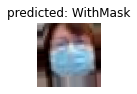

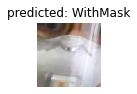

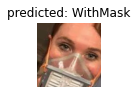

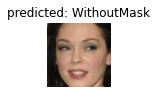

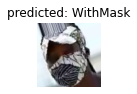

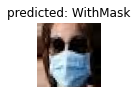

In [27]:
visualize_model(pretrained_model)

plt.ioff()
plt.show()